#### download dependencies

In [1]:
!pip install wget
!pip install segmentation-models-pytorch

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=ebd60e02c2e859abb99d28a5a67965f45130e8d0b7bba740952f28a478aa7d30
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
     |████████████████████████████████| 51kB 3.9MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=04dfa1d3f6fd2f8a289c95688cc0168b56c78a53330e3148955b466b7e3608a7
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=6f820bc9d81e4a6220e193e813eca1681977a6c25ecde9e8f1886263c317afc4
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmod

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### download data

In [3]:
import download_data as dd
dd.download_skyf_data()

/content/download_data.py:24: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 24 of the file /content/download_data.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(wp.text)
47it [03:34,  4.55s/it]
0it [00:00, ?it/s]

Download Time: 3.57 min.


47it [04:00,  5.12s/it]


Unzip Time: 4.01 min.


47it [00:03, 13.61it/s]
  0%|          | 0/1 [00:00<?, ?it/s]

Download Time: 0.06 min.


100%|██████████| 1/1 [00:10<00:00, 10.16s/it]

Download Time: 0.17 min.


#### Clean data

In [4]:
import pandas as pd
import preprocess as pp
import sky_dataset as sd
import yaml
import random
from torch.utils.data import DataLoader
import os

with open("config.yaml") as f:
    config = yaml.load(f)

images_dir = config["path"]["images"]
masks_dir = config["path"]["masks"]
data_root = config["path"]["root"]

metadata = pd.read_csv( os.path.join(data_root,"complete_table_with_mcr.csv"))

In [5]:
metadata.head(3)

,Filename,CamId,Year,hoiem_MCR,hoiem_Accuracy,svetlana2010_MCR,svetlana2010_Accuracy,tcwc_MCR,tcwc_Accuracy,Date,Latitude,Longitude,Month,Day,Timezone,Hour,Min,TempM,TempI,DewPtM,DewPtI,Hum,WspdM,WspdI,WgustM,WgustI,WDirD,WDirE,VisM,VisI,PressureM,PressureI,WindChillM,WindChillI,HeatIndexM,HeatIndexI,PrecipM,PrecipI,Conds,Icon,...,dirty,daylight,night,sunrisesunset,dawndusk,sunny,clouds,fog,storm,snow,warm,cold,busy,beautiful,flowers,spring,summer,autumn,winter,glowing,colorful,dull,rugged,midday,dark,bright,dry,moist,windy,rain,ice,cluttered,soothing,stressful,exciting,sentimental,mysterious,boring,gloomy,lush
0,20130101_091628.jpg,10066,2013,0.100599,0.899401,0.083451,0.916549,0.352917,0.647083,735235.428102,46.383333,11.85,1,1,1,7,55,-3.0,26.6,-11.0,12.2,55.0,20.4,12.7,-9999.0,-9999.0,120.0,ESE,-9999.0,-9999.0,1014.0,29.95,-9.1,15.7,-9999.0,-9999.0,-9999.0,-9999.0,Clear,clear,...,0.547049,0.441979,0.322453,0.351293,0.313419,0.000000,0.697720,0.379395,0.330979,0.192886,0.000000,0.321365,0.051338,0.177092,0.090084,0.123589,0.047424,0.095561,0.241026,0.145982,0.072481,0.701962,0.509484,0.000000,0.302783,0.139693,0.303083,0.440760,0.334852,0.268910,0.201019,0.578970,0.175610,0.465193,0.115777,0.194916,0.091037,0.574105,0.475860,0.084300
1,20130101_114638.jpg,10066,2013,0.096901,0.903099,0.017214,0.982786,0.379089,0.620911,735235.532384,46.383333,11.85,1,1,1,16,0,-3.0,27.0,-8.0,17.0,55.0,13.0,8.1,NaN,NaN,110.0,ESE,70.0,44.0,NaN,NaN,-999.0,-999.0,-9999.0,-9999.0,NaN,NaN,Partly Cloudy,partlycloudy,...,0.534179,0.571297,0.243518,0.309915,0.324350,0.043510,0.598105,0.180688,0.259268,0.242280,0.087142,0.313409,0.089964,0.208543,0.036352,0.145673,0.100517,0.203845,0.311811,0.218987,0.192250,0.580514,0.572702,0.028491,0.254115,0.244696,0.396782,0.365263,0.254310,0.179551,0.216055,0.620019,0.227166,0.327942,0.211095,0.264720,0.075191,0.467294,0.376086,0.124136
2,20130101_125725.jpg,10066,2013,0.107018,0.892982,0.075417,0.924583,0.467018,0.532982,735235.581539,46.383333,11.85,1,1,1,13,55,-2.0,28.4,-8.0,17.6,64.0,22.2,13.8,-9999.0,-9999.0,120.0,ESE,-9999.0,-9999.0,1012.0,29.89,-8.1,17.5,-9999.0,-9999.0,-9999.0,-9999.0,Clear,clear,...,0.510784,0.515002,0.280690,0.396395,0.415126,0.075262,0.710545,0.237895,0.318913,0.198160,0.081701,0.286634,0.194882,0.239971,0.086100,0.144543,0.144855,0.188933,0.202455,0.257138,0.244403,0.545727,0.530176,0.028870,0.282897,0.287472,0.436440,0.298745,0.293430,0.219256,0.172771,0.587002,0.290493,0.327276,0.248607,0.262659,0.165920,0.492840,0.335585,0.182317


43999


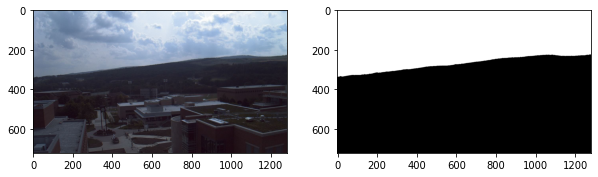

In [7]:
import cv2
import matplotlib.pyplot as plt

dark_filter = (metadata["dark"] > 0.0) & (metadata["dark"] < 0.45)
fog_filter = (metadata["fog"] > 0.0) & (metadata["fog"] < 0.5)

cond = fog_filter & dark_filter 
path_list = pp.get_filtered_images(metadata, images_dir, masks_dir, cond)

print(len(path_list))

#plot random instance
fig, axes = plt.subplots(1,2, figsize=(10,6))
rand = random.randint(0, len(path_list))
image = cv2.imread(path_list[rand][0])
mask = cv2.imread(path_list[rand][1])
axes[0].imshow(cv2.cvtColor( image, cv2.COLOR_BGR2RGB) )
axes[1].imshow(mask)

#### Intialize Dataset and dataloader

In [8]:
shuffled_path_list = random.sample(path_list, len(path_list))

train_split = config["train"]["train_split"]

train_list = shuffled_path_list[: int(len(path_list)*train_split) ]
val_list = shuffled_path_list[int(len(path_list)*train_split) : ]

mean = config["train"]["normalize"]["imagenet"]["mean"]
std = config["train"]["normalize"]["imagenet"]["std"]

transform = {"train" : pp.Compose([pp.Rescale((128,200)),
                     pp.RandomCrop(128,True),
                     pp.Normalize_Image_and_Correct_Mask(mean,std)]),
            "val" : pp.Compose([pp.Rescale((128,128)),
                                pp.Normalize_Image_and_Correct_Mask(mean,std)]) }

train_dataset = sd.dataset(train_list,images_dir,transform["train"])
val_dataset = sd.dataset(val_list,images_dir , transform["val"])

batch_size = 8 #config["train"]["batch_size"]

train_dl = DataLoader(train_dataset,
                     batch_size=batch_size,
                     shuffle=True,
                     collate_fn= sd.collate)

val_dl = DataLoader(val_dataset,
                    batch_size= batch_size,
                    collate_fn= sd.collate)

#### example 

In [9]:
# DeNormalization of Tensor
def deNormalize(tensor,mean,std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [10]:
# Get a Batch from DataLoader
it = iter(train_dl)
print(len(train_dataset),len(val_dataset))
x = next(it)
print(x["images"].shape, x["masks"].shape)

34270 3811
torch.Size([8, 3, 128, 128]) torch.Size([8, 1, 128, 128])


In [11]:
# select an instance of a batch and denormalize it
img = x["images"][2]
msk = x["masks"][2]
print(img.shape, msk.shape)
print(img.min() , img.max())

dn_img = deNormalize(img, mean, std)
print( dn_img.min(), dn_img.max())

torch.Size([3, 128, 128]) torch.Size([1, 128, 128])
tensor(-2.1179) tensor(1136.3572)
tensor(0.) tensor(255.0000)


(128, 128, 3)
torch.Size([128, 128])


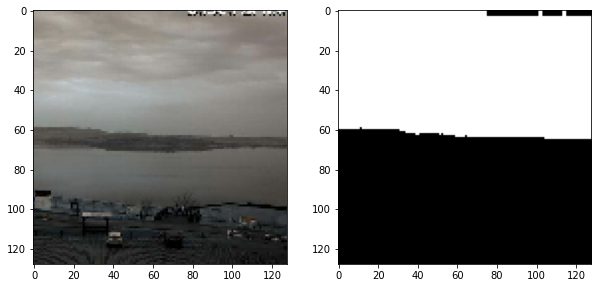

In [12]:
# plot denormalized data instance
import utils
import numpy as np
image = np.array( np.floor( np.transpose(dn_img , (1,2,0)))).astype(np.int64)
print(image.shape)
mask = np.squeeze(msk, 0)
print(mask.shape)
fig , axes = plt.subplots(1, 2, figsize=(10,6))
axes[0].imshow( image )
axes[1].imshow( utils.correct_binary(mask, True) ,cmap="gray")

#### initialize model

In [13]:
import torch
import segmentation_models_pytorch as smp
num_class = 2

model = smp.Unet('resnet34', encoder_weights='imagenet',classes=num_class,activation= None)




Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#### initialize optimizer

In [15]:
import torch.optim as optim
from torch.optim import lr_scheduler
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

#### training

In [16]:
epochs = 15
save_path = "/content/drive/My Drive/sky_model_baseline.pt" #config["train"]["save_path"]


In [17]:
# number of batches
len(train_dl),len(val_dl)

(4284, 477)

In [ ]:
import loss
from tqdm import tqdm_notebook as tqdm
import time
from torch.autograd import Variable

def train():
    best_loss = 1e10
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch , epochs-1))
        print("=="*10)
        start = time.time()
        

        model.train()
        sum_loss = 0.0
        num = 0.0
        print("Train...")
        
        for sample in tqdm(train_dl):
            
            inputs = sample['images'].to(device)
            target = sample['masks'].to(device)
            
            optimizer_ft.zero_grad()
            output = model(inputs)
            train_loss = loss.bce_loss(output, target.float() )

            
            train_loss.backward()
            optimizer_ft.step()

            sum_loss += float(train_loss)
            num += inputs.size(0)
        print("Train loss ",sum_loss/num)
        

        model.eval()
        sum_loss = 0.0
        num = 0.0
        print("Validation...")
        
        for sample in tqdm(val_dl):

            inputs = sample['images'].to(device)
            target = sample['masks'].to(device)

            
            output = model(inputs)
            val_loss = loss.bce_loss(output, target.float())

            sum_loss += float(val_loss)
            num += inputs.size(0)
            
        print("Validation Loss ", sum_loss/num)

        if sum_loss/num < best_loss:
            print("Saving Best Model")
            best_loss = sum_loss/num
            torch.save(model, save_path)
        print("Epoch time ",(time.time() - start)//60,"minutes")
        print("Best Validation Loss ", best_loss)
        


In [ ]:
print("Start Training...")
start = time.time()
model.to(device)
train()
end = time.time()
print("Total Training Time : ", (end- start)//60 , "minutes" )

#### *TEMPORARY*

In [18]:
import torch
model = torch.load(save_path)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set

In [19]:
def get_metrics(output, target, epoch, history, mode, smooth = 1):

    bce_loss_mean, bce_loss_batch = loss.BCE_loss_batch(output, target.float())
    history["BCE_loss"].setdefault(epoch, {}).setdefault(mode , []).extend([l.item() for l in bce_loss_batch])

    dice_score_mean, dice_score_batch = loss.DICEScore_batch(output, target.float(), smooth)
    history["DICEScore"].setdefault(epoch, {}).setdefault(mode , []).extend([l.item() for l in dice_score_batch])

    iou_score_mean, iou_score_batch = loss.IoUScore_batch(output, target.float(), smooth)
    history["IoUScore"].setdefault(epoch, {}).setdefault(mode , []).extend([l.item() for l in iou_score_batch])    

    return bce_loss_mean

def print_metrics(epoch, history, mode, length):
    print("{} || BCELoss {:.4f} || DICEScore {:.4f} || IoUScore {:.4f}".
          format(mode,
                 sum(history["BCE_loss"][epoch][mode])/length[mode],
                 sum(history["DICEScore"][epoch][mode])/length[mode],
                 sum(history["IoUScore"][epoch][mode])/length[mode]))

In [ ]:
import loss
from tqdm.notebook import tqdm
length = {"train":len(train_dataset), "val":len(val_dataset)}

model.to(device)

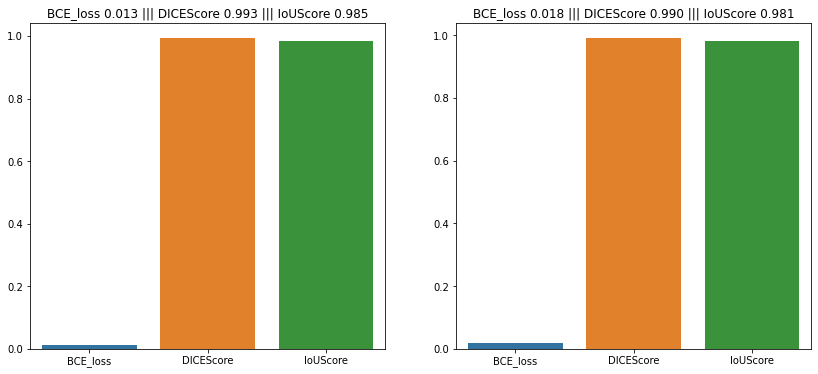

In [30]:
import seaborn as sns
fig, ax = plt.subplots(1,2, figsize=(14,6))
ax[0].set_title("BCE_loss {:.3f} ||| DICEScore {:.3f} ||| IoUScore {:.3f}".format(sum(history["BCE_loss"][0]["train"])/length["train"],
                                                            sum(history["DICEScore"][0]["train"])/length["train"],
                                                            sum(history["IoUScore"][0]["train"])/length["train"]))
sns.barplot(x = ["BCE_loss", "DICEScore", "IoUScore"], y = [ sum(history["BCE_loss"][0]["train"])/length["train"],
                                                            sum(history["DICEScore"][0]["train"])/length["train"],
                                                            sum(history["IoUScore"][0]["train"])/length["train"]], ax = ax[0])
ax[1].set_title("BCE_loss {:.3f} ||| DICEScore {:.3f} ||| IoUScore {:.3f}".format(sum(history["BCE_loss"][0]["val"])/length["val"],
                                                            sum(history["DICEScore"][0]["val"])/length["val"],
                                                            sum(history["IoUScore"][0]["val"])/length["val"]))
sns.barplot(x = ["BCE_loss", "DICEScore", "IoUScore"], y = [ sum(history["BCE_loss"][0]["val"])/length["val"],
                                                            sum(history["DICEScore"][0]["val"])/length["val"],
                                                            sum(history["IoUScore"][0]["val"])/length["val"]], ax = ax[1])

In [21]:


model.eval()
mode = "train"
for sample in tqdm(train_dl):    
    inputs = sample['images'].to(device)
    target = utils.expand_target( sample['masks'].to(device) )
    output = model(inputs)
    mode_loss = get_metrics(output, target, epoch, history, mode)
print_metrics(epoch, history, mode, length)

mode = "val"
for sample in tqdm(val_dl):
    inputs = sample['images'].to(device)
    target = utils.expand_target( sample['masks'].to(device) )
    output = model(inputs)

    mode_loss = get_metrics(output, target, epoch, history, mode)
print_metrics(epoch, history, mode, length)



train || BCELoss 0.0129 || DICEScore 0.9925 || IoUScore 0.9853



val || BCELoss 0.0185 || DICEScore 0.9901 || IoUScore 0.9805


In [23]:
import pickle
a_file = open("/content/drive/My Drive/trained_ss_eval_ss_history.pkl", "wb")
pickle.dump(history, a_file)
a_file.close()

In [ ]:
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
val_iter = iter(val_dl)

In [ ]:
sample = next(val_iter)

In [ ]:
import random
idx = random.randint(0, sample["images"].shape[0] )
pred = model(sample["images"].to(device))
pred_mask = torch.round(torch.sigmoid(pred))[idx][0]

img = sample["images"][idx]
msk = sample["masks"][idx]
print(img.shape, msk.shape)
print(img.min() , img.max())

dn_img = deNormalize(img, mean, std)
print( dn_img.min(), dn_img.max())

torch.Size([3, 128, 128]) torch.Size([1, 128, 128])
tensor(-2.1179) tensor(1111.4192)
tensor(0.) tensor(255.)


(128, 128, 3)
torch.Size([128, 128])


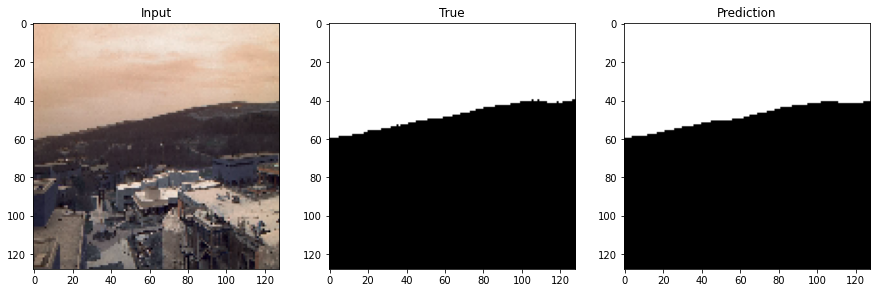

In [ ]:
import utils
import numpy as np
image = np.array( np.floor( np.transpose(dn_img , (1,2,0)))).astype(np.int64)
print(image.shape)
mask = np.squeeze(msk, 0)
print(mask.shape)
fig , axes = plt.subplots(1, 3, figsize=(15,6))

axes[0].set_title("Input")
axes[0].imshow( image )
axes[1].set_title("True")
axes[1].imshow( utils.correct_binary(mask, True), cmap="gray" )
axes[2].set_title("Prediction")
axes[2].imshow( pred_mask.cpu().detach().numpy(), cmap = "gray")

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict(image_path):
    org_img = cv2.imread(image_path)
    resized = cv2.resize(org_img, (128,128), interpolation=cv2.INTER_NEAREST)
    image = np.transpose(resized, (2, 0, 1))
    image = image[None,...]
    image = torch.from_numpy(image).float()
    pred = model(image.to(device))
    pred_mask = torch.round(torch.sigmoid(pred))[0][0]
    fig, axes = plt.subplots(1,2 , figsize=(14,8))
    axes[0].imshow(resized)
    axes[1].imshow(pred_mask.detach().numpy(),cmap="gray")

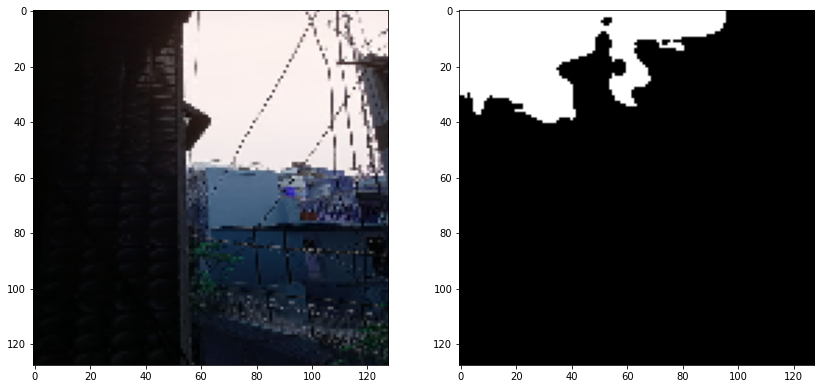

In [ ]:
predict("test3.jpg")

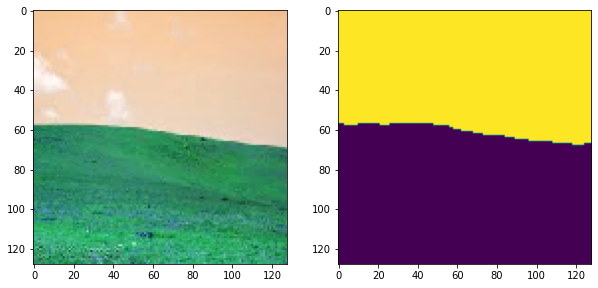

In [ ]:
predict("test.jpg")

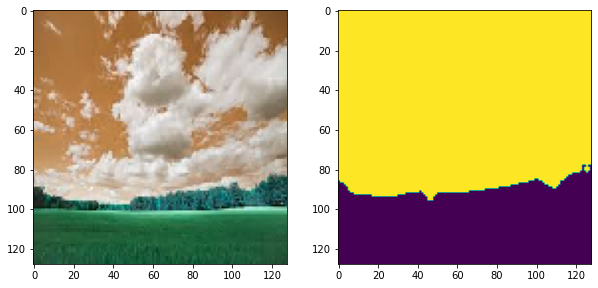

In [ ]:
predict("test1.jpg")

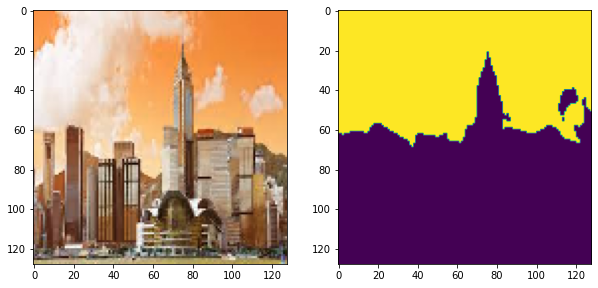

In [ ]:
predict("test2.jpg")

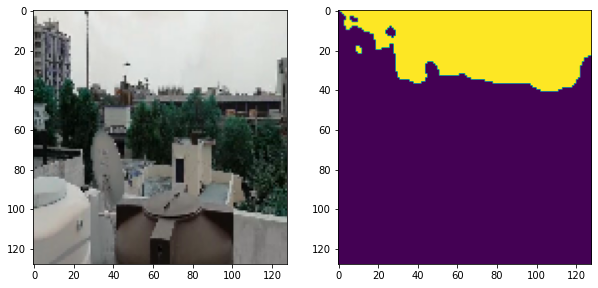

In [ ]:
predict("test5.jpg")

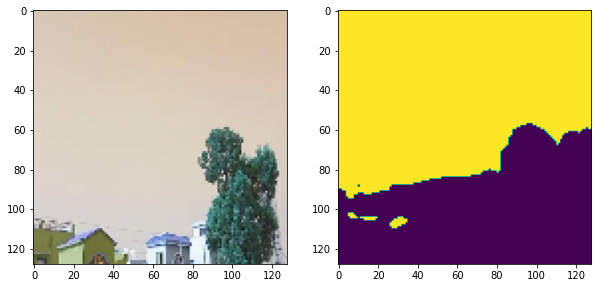

In [ ]:
predict("test4.jpg")

4282